# Generate simulation data

In [1]:
import simulation.multimodal_simulation as simulation
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch

In [2]:
num_cluster = 10
sample_size = 2000
latent_code_dim = 50
observed_data_dim = 1000
sigma_1 = 0.1
sigma_2 = 0.5
decay_coef_1 = 0.9 
decay_coef_2 = 0.2

data = simulation.basic_simulator(num_cluster, sample_size,
                                  observed_data_dim, observed_data_dim,
                                  latent_code_dim,
                                  sigma_1, sigma_2,
                                  decay_coef_1, decay_coef_2
                                  )

data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_true = data['true_cluster'].astype(str)

## Visualization of features of two modalities

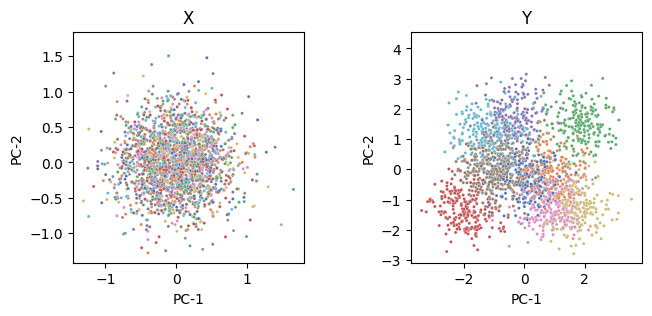

In [3]:
%matplotlib inline
pca = PCA(n_components=2)
pc = pca.fit_transform(data_a)
pd_plot_combine = pd.DataFrame(data=pc, columns=['PC-1', 'PC-2'])
pd_plot_combine.insert(value=label_true, column='Label', loc=0)

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
sns.scatterplot(x='PC-1', y='PC-2', palette="deep", data=pd_plot_combine, hue='Label', edgecolors=None, s=5,
                legend=False)
plt.axis('square')
plt.title('X')

pca = PCA(n_components=2)
pc = pca.fit_transform(data_b)
pd_plot_combine = pd.DataFrame(data=pc, columns=['PC-1', 'PC-2'])
pd_plot_combine.insert(value=label_true, column='Label', loc=0)
plt.subplot(1,2,2)
sns.scatterplot(x='PC-1', y='PC-2', palette="deep", data=pd_plot_combine, hue='Label', edgecolors=None, s=5,
                legend=False)
plt.axis('square')
plt.title('Y')
plt.show()

# adMDM for representation learning

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
from adMDM_package.adMDM import *
batch_size = 500
latent_dim = 10

feature_x = torch.Tensor(data_a)
feature_y = torch.Tensor(data_b)

dataset = TensorDataset(feature_x.to(device), feature_y.to(device))  # create your datset
train_dl = DataLoader(dataset, batch_size, shuffle=True)  # create your dataloader

x_dim = feature_x.shape[1]
y_dim = feature_y.shape[1]
z_dim = latent_dim
mv = adMDM(x_dim=x_dim, y_dim=y_dim, z_dim=z_dim, device=device)
mv.to(device)
losses_ax, losses_gx, losses_d = mv.fit(train_dl, 
                                        lr=1e-3,epochs_ae=500,epochs_inner=501,epoch_ad=3)

latent_x, latent_y = mv.inference(feature_x.to(device), feature_y.to(device))


Optimize autoencoder losses
Epoch [1/500]
	loss_ax: 0.0927	loss_ay: 0.1549
Epoch [101/500]
	loss_ax: 0.0336	loss_ay: 0.0673
Epoch [201/500]
	loss_ax: 0.0282	loss_ay: 0.0554
Epoch [301/500]
	loss_ax: 0.0234	loss_ay: 0.0439
Epoch [401/500]
	loss_ax: 0.0194	loss_ay: 0.0370
Optimize adversarial and autoencoder losses
x Epoch [1/501]
	loss_gx: -5265.6011
	loss_dx: 0.2359
	loss_ay: 0.0437
x Epoch [101/501]
	loss_gx: -35221.4102
	loss_dx: 0.9125
	loss_ay: 0.0269
x Epoch [201/501]
	loss_gx: -65013.7227
	loss_dx: -15.6993
	loss_ay: 0.0198
x Epoch [301/501]
	loss_gx: -94078.2891
	loss_dx: -22.8013
	loss_ay: 0.0155
x Epoch [401/501]
	loss_gx: -122081.4609
	loss_dx: -1.9966
	loss_ay: 0.0128
x Epoch [501/501]
	loss_gx: -148532.3594
	loss_dx: -240.9873
	loss_ay: 0.0111
y Epoch [1/501]
	loss_gy: -166226.4375
	loss_dy: -173.9057
	loss_ay: 0.0303
y Epoch [101/501]
	loss_gy: -1911217.7500
	loss_dy: -118.9246
	loss_ay: 0.0232
y Epoch [201/501]
	loss_gy: -3656518.5000
	loss_dy: 55.3022
	loss_ay: 0.0185
y 

# Visualization of representations

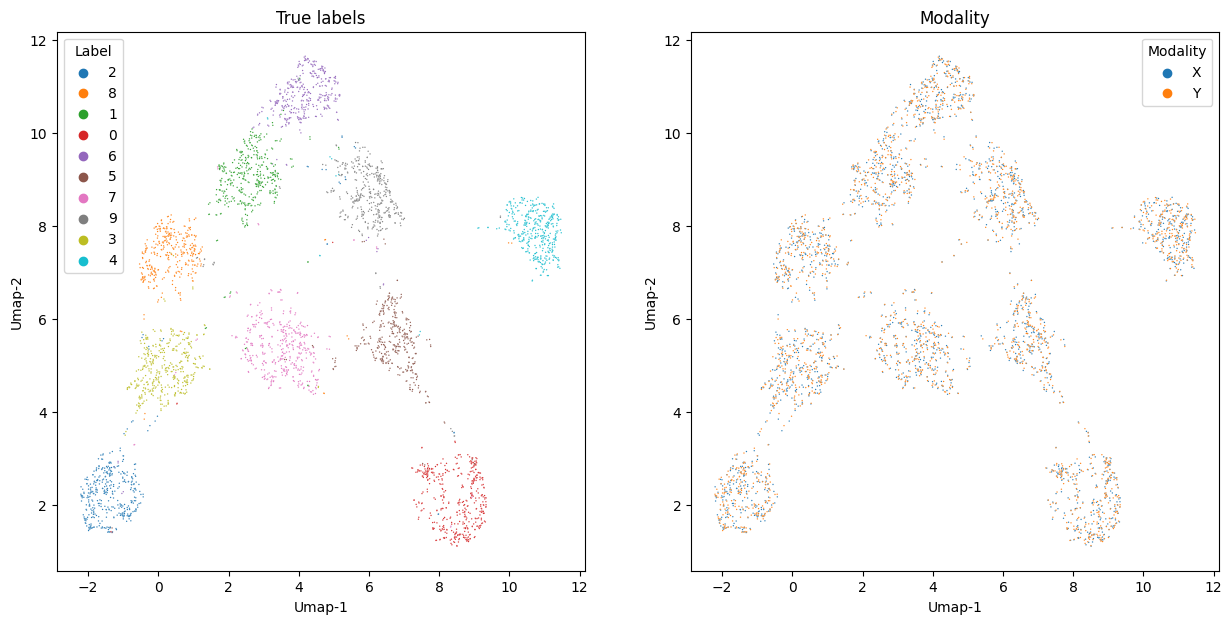

In [7]:
latent_x = latent_x.detach().cpu().numpy()
latent_y = latent_y.detach().cpu().numpy()
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
pd_plot_combine = np.concatenate([latent_x, latent_y])
umap = UMAP()
umap2 = umap.fit_transform(pd_plot_combine)
pd_plot_combine = pd.DataFrame(data=umap2, columns=['Umap-1', 'Umap-2'])
pd_plot_combine.insert(value=np.concatenate([label_true, label_true], axis=0), column='Label', loc=0)
data_source = ['X'] * label_true.size + ['Y'] * label_true.size
pd_plot_combine.insert(value=data_source, column='Modality', loc=0)

sns.scatterplot(x='Umap-1', y='Umap-2', data=pd_plot_combine, hue='Label', edgecolors=None, s=1)
plt.title('True labels')
plt.subplot(1, 2, 2)
sns.scatterplot(x='Umap-1', y='Umap-2', data=pd_plot_combine, hue='Modality', edgecolors=None, s=1)
plt.title('Modality')
plt.show()